In [ ]:
!curl -LJO https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/main/data/car_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18812  100 18812    0     0  79062      0 --:--:-- --:--:-- --:--:-- 79375


In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#Leo los datos y elimino las columnas innecesarias

datos = pd.read_csv("car_data.csv")

datos = datos.drop(columns=["Car_Name", "Owner"])

#Separo los sets

training_set = datos[datos["Set"] == "Train"]
test_set = datos[datos["Set"] == "Test"]
validation_set = datos[datos["Set"] == "Validation"]

#Elimino el dato del set

training_set = training_set.drop(columns=["Set"])
test_set = test_set.drop(columns=["Set"])
validation_set = validation_set.drop(columns=["Set"])

#Veo las proporciones de cada set con una funcion, esto me da un aproximado de la probabilidad de aparcicion de cada variables categorica en el set

def proporciones(data, nombre):

  p_dealer_train = data["Seller_Type"].value_counts()["Dealer"] / len(data)
  p_ind_train = 1 - p_dealer_train

  p_manual_train = data["Transmission"].value_counts()["Manual"] / len(data)
  p_auto_train = 1 - p_manual_train

  p_petrol_train = data["Fuel_Type"].value_counts()["Petrol"] / len(data)
  p_diesel_train = data["Fuel_Type"].value_counts()["Diesel"] / len(data)
  p_cng_train = 1 - p_petrol_train - p_diesel_train

  print("Proporciones del " + nombre + " set:" +
        "\nDealers:" + str(p_dealer_train) + " Independientes:" + str(p_ind_train) +
        "\nManuales:" + str(p_manual_train) + " Automáticos:" + str(p_auto_train) +
        "\nPetrol:" + str(p_petrol_train) + " Diesel:" + str(p_diesel_train) + " CNG:" + str(p_cng_train) + "\n\n")

proporciones(training_set, "training")
proporciones(test_set, "test")
proporciones(validation_set, "validation")

#Se observa que los tres sets siguen aproximadamente las mismas proporciones


Proporciones del training set:
Dealers:0.6333333333333333 Independientes:0.3666666666666667
Manuales:0.8592592592592593 Automáticos:0.14074074074074072
Petrol:0.7962962962962963 Diesel:0.1962962962962963 CNG:0.007407407407407418


Proporciones del test set:
Dealers:0.7619047619047619 Independientes:0.23809523809523814
Manuales:0.9047619047619048 Automáticos:0.09523809523809523
Petrol:0.7619047619047619 Diesel:0.23809523809523808 CNG:5.551115123125783e-17


Proporciones del validation set:
Dealers:0.8 Independientes:0.19999999999999996
Manuales:1.0 Automáticos:0.0
Petrol:0.8 Diesel:0.2 CNG:-5.551115123125783e-17




In [ ]:
#Creo el codificador One Hot con el drop if binary para que dej as variables categoricas dobles como binarias

encoder = OneHotEncoder(drop="if_binary")

#Aplico la tf a las variables categoricas

codificado = encoder.fit_transform(training_set[["Fuel_Type", "Transmission", "Seller_Type"]])

#Las convierto en dataframe
cols = encoder.get_feature_names_out(["Fuel_Type", "Transmission", "Seller_Type"])

df_onehot = pd.DataFrame(codificado.toarray(), columns=cols)


In [ ]:
#Creo el transformador polinomico de grado 3, con include_bias

pol = PolynomialFeatures(degree = 3, include_bias = False)

#Transformo las veriables numéricas

var_poly = pol.fit_transform(training_set[["Kms_Driven", "Present_Price", "Year"]])

cols_poly = pol.get_feature_names_out(["Kms_Driven", "Present_Price", "Year"])

df_poly = pd.DataFrame(var_poly, columns=cols_poly)

print(df_poly)


     Kms_Driven  Present_Price    Year  Kms_Driven^2  \
0       27000.0           5.59  2014.0  7.290000e+08   
1       43000.0           9.54  2013.0  1.849000e+09   
2        6900.0           9.85  2017.0  4.761000e+07   
3        5200.0           4.15  2011.0  2.704000e+07   
4        2071.0           9.83  2018.0  4.289041e+06   
..          ...            ...     ...           ...   
265     33988.0          11.60  2016.0  1.155184e+09   
266     60000.0           5.90  2015.0  3.600000e+09   
267     87934.0          11.00  2009.0  7.732388e+09   
268      9000.0          12.50  2017.0  8.100000e+07   
269      5464.0           5.90  2016.0  2.985530e+07   

     Kms_Driven Present_Price  Kms_Driven Year  Present_Price^2  \
0                   150930.00       54378000.0          31.2481   
1                   410220.00       86559000.0          91.0116   
2                    67965.00       13917300.0          97.0225   
3                    21580.00       10457200.0          17.

In [ ]:
#Hago todo junto con column transformer

#Defino la transformacion para las variables numericas, uso Polynomial Features de grado 3 y escalo
tf_numericas = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("escalar", StandardScaler())
])

#Para las categóricas uso OneHot con drop if_binary para que las variables con dos categorías queden como binarias
tf_categoricas = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="if_binary")),
])

#Defino la transformacion completa
preproceso = ColumnTransformer(transformers=[
    ("numericas", tf_numericas, ["Kms_Driven", "Present_Price", "Year"]),
    ("categoricas", tf_categoricas, ["Fuel_Type", "Transmission", "Seller_Type"])
])

#Transformo mi set de entrenamiento
training_set_tf = preproceso.fit_transform(training_set)

#Imprimo una muestra para ver
print(training_set_tf)


[[-0.25086677 -0.23808975  0.12687127 ...  1.          1.
   0.        ]
 [ 0.14481679  0.20350422 -0.21568117 ...  0.          1.
   0.        ]
 [-0.74794424  0.23816097  1.1545286  ...  1.          1.
   0.        ]
 ...
 [ 1.25604461  0.3667263  -1.58589094 ...  1.          1.
   0.        ]
 [-0.69601077  0.53442021  1.1545286  ...  0.          1.
   0.        ]
 [-0.78345684 -0.20343301  0.81197616 ...  1.          1.
   0.        ]]


In [ ]:
#Defino otro pipeline que haga el preprocesamiento y despues entrene con regresion lineal

modelo = Pipeline(steps=[
    ("preproceso", preproceso),
    ("reg lineal", LinearRegression())
])

#En total el modelo tiene 25 parámetros a definir:
#-por el lado de las variables numéricas se tienen 19, ya que son 3 para las lineales, 6 para las cuadradas y 10 para las cubicas
#-en cuanto a las categóricas hay 5, 3 para la categórica de 3 categorías y 2 para las binarias
#-finalmente queda la variable de bias

display(modelo)


Pipeline(steps=[('preproceso',
                 ColumnTransformer(transformers=[('numericas',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('escalar',
                                                                   StandardScaler())]),
                                                  ['Kms_Driven',
                                                   'Present_Price', 'Year']),
                                                 ('categoricas',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['Fuel_Type', 'Transmission',
                                                   'Seller_Type'])])),
                ('reg lineal', LinearRegression())])

In [ ]:
#Separo las variables de entrada de la salida

X = training_set.drop(columns=["Selling_Price"])
y = training_set["Selling_Price"]

#Hago lo mismo con el set de validacion

X_val = validation_set.drop(columns=["Selling_Price"])
y_val = validation_set["Selling_Price"]

#Entreno
modelo.fit(X, y)

#Calculo ambos errores
train_error = np.mean((y - modelo.predict(X))**2)

val_error = np.mean((y_val - modelo.predict(X_val))**2)

print("Error de entrenamiento: " + str(train_error))
print("Error de validación: " + str(val_error))

Error de entrenamiento: 0.472692355968173
Error de validación: 0.5419991553478682


El mejor lambda de los analizados es: 0.0002319246231155779


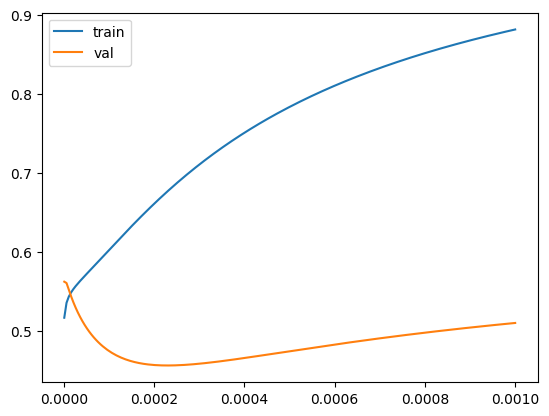

El error de testeo es: 0.341469434878396


In [ ]:
#Defino los lambdas a analizar

lambdas = np.linspace(1e-6, 1e-3, 200)

#Creo variables para guardar el error
hist_error_train = []
hist_error_val = []

#Variable para guardar el error
lambda_opt = 0.0
aux_error_min = 100

for i in lambdas:

  #Creo el modelo regularizado con Ridge
  modelo_reg = Pipeline(steps=[
      ("preproceso", preproceso),
      ("reg lineal regularizada", Ridge(alpha=i))
  ])

  #Entreno
  modelo_reg.fit(X, y)

  #Calculo errores y guardo
  train_error = np.mean((y - modelo_reg.predict(X))**2)
  val_error = np.mean((y_val - modelo_reg.predict(X_val))**2)

  hist_error_train.append(train_error)
  hist_error_val.append(val_error)

  #Si el error de validación es menor actualizo el lambda optimo
  if val_error < aux_error_min:
    aux_error_min = val_error
    lambda_opt = i

print("El mejor lambda de los analizados es: " + str(lambda_opt))

#Ploteo el error en funcion del hiperparámetro
plt.plot(lambdas, hist_error_train, label="train")
plt.plot(lambdas, hist_error_val, label="val")
plt.legend()
plt.show()

#Se observa que logicamente el error de entrenamiento aumenta monotonamente con lambda, mientras que el de validacion
#presenta el mínimo en el lambda optimo

#Creo el pipeline con el lambda optimo
modelo_reg = Pipeline(steps=[
    ("preproceso", preproceso),
    ("reg lineal regularizada", Ridge(alpha=lambda_opt))
])

modelo_reg.fit(X, y)

#Separo entradas de salidas
y_test = test_set["Selling_Price"]
X_test = test_set.drop(columns=["Selling_Price"])

#Observo el error
test_error = np.mean((y_test - modelo_reg.predict(X_test))**2)

print("El error de testeo es: " + str(test_error))
